## 准备数据

torchtext常见API一览

* torchtext.data.Example : 用来表示一个样本，数据和标签
* torchtext.vocab.Vocab: 词汇表，可以导入一些预训练词向量
* torchtext.data.Datasets: 数据集类，__getitem__返回 Example实例, torchtext.data.TabularDataset是其子类。
* torchtext.data.Field : 用来定义字段的处理方法（文本字段，标签字段）创建 Example时的 预处理，batch 时的一些处理操作。
* torchtext.data.Iterator: 迭代器，用来生成 batch
* torchtext.datasets: 包含了常见的数据集.

In [2]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import re
import string

MAX_WORDS = 10000 # 仅考虑最高频的10000个词
MAX_LEN = 200 # 每个样本保留200个词的长度
BATCH_SIZE = 20
train_data_path = './data/imdb/train.tsv'
test_data_path = './data/imdb/test.tsv'
train_token_path = './data/imdb/train_token.tsv'
test_token_path = './data/imdb/test_token.tsv'
train_samples_path = './data/imdb/train_samples/'
test_samples_path = './data/imdb/test_samples/'

In [3]:
# 构建词典

word_count_dict = {}

# 清洗文本

def clean_text(text):
    lowercase = text.lower().replace("\n", " ")
    stripped_html = re.sub('<br />', ' ', lowercase)
    cleaned_punctuation = re.sub('[%s]'%re.escape(string.punctuation), '', stripped_html)
    return cleaned_punctuation

with open(train_data_path, 'r', encoding='utf-8') as f:
    for line in f:
        label, text = line.split('\t')
        cleaned_text = clean_text(text)
        for word in cleaned_text.split(' '):
            word_count_dict[word] = word_count_dict.get(word, 0) + 1

df_word_dict = pd.DataFrame(pd.Series(word_count_dict, name='count'))
df_word_dict = df_word_dict.sort_values(by='count', ascending=False)

df_word_dict = df_word_dict[0 : MAX_WORDS-2]
df_word_dict['word_id'] = range(2, MAX_WORDS)

word_id_dict = df_word_dict['word_id'].to_dict()

df_word_dict.head(10)

,count,word_id
the,268230,2
and,129713,3
a,129479,4
of,116497,5
to,108296,6
is,85615,7
,84074,8
in,74715,9
it,62587,10
i,60837,11


In [4]:
# 转换token

# 填充文本

def pad(data_list, pad_length):
    padded_list = data_list.copy()
    if len(data_list) > pad_length:
        padded_list = data_list[-pad_length:]
    if len(data_list) < pad_length:
        padded_list = [1] * (pad_length - len(data_list)) + data_list
    return padded_list

def text_to_token(text_file, token_file):
    with open(text_file, 'r', encoding='utf-8') as fin,\
        open(token_file, 'w', encoding='utf-8') as fout:
        for line in fin:
            label, text = line.split('\t')
            cleaned_text = clean_text(text)
            word_token_list = [word_id_dict.get(word, 0) for word in cleaned_text.split(' ')]
            pad_list = pad(word_token_list, MAX_LEN)
            out_line = label + '\t' + " ".join(str(x) for x in pad_list)
            fout.write(out_line + '\n')

text_to_token(train_data_path, train_token_path)
text_to_token(test_data_path, test_token_path)

In [5]:
import os

if not os.path.exists(train_samples_path):
    os.mkdir(train_samples_path)

if not os.path.exists(test_samples_path):
    os.mkdir(test_samples_path)

def split_samples(token_path, samples_dir):
    with open(token_path, 'r', encoding='utf-8') as fin:
        i = 0
        for line in fin:
            with open(samples_dir+"%d.txt"%i, 'w', encoding='utf-8') as fout:
                fout.write(line)
            i = i + 1

split_samples(train_token_path, train_samples_path)
split_samples(test_token_path, test_samples_path)

In [7]:
print(os.listdir(train_samples_path)[0:10])

['0.txt', '1.txt', '10.txt', '100.txt', '1000.txt', '10000.txt', '10001.txt', '10002.txt', '10003.txt', '10004.txt']


In [8]:
import os
import torch
from  torch.utils.data import Dataset, DataLoader

class imdbDataset(Dataset):
    def __init__(self, samples_dir):
        self.samples_dir = samples_dir
        self.samples_paths = os.listdir(samples_dir)

    def __len__(self):
        return len(self.samples_paths)

    def __getitem__(self, index):
        path = self.samples_dir + self.samples_paths[index]
        with open(path, 'r', encoding='utf-8') as f:
            line = f.readline()
            label, tokens = line.split('\t')
            label = torch.tensor([float(label)], dtype=torch.float)
            feature = torch.tensor([int(x) for x in tokens.split(' ')], dtype=torch.long)
            return (feature, label)

ds_train = imdbDataset(train_samples_path)
ds_test = imdbDataset(test_samples_path)

print(len(ds_train))
print(len(ds_test))

dl_train = DataLoader(dataset=ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = DataLoader(dataset=ds_test, batch_size=BATCH_SIZE)

for feature, label in dl_train:
    print(feature)
    print(label)
    break

20000
5000
tensor([[   1,    1,    1,  ...,    6,   10,    8],
        [  86,  285,   12,  ...,    2,  465,    8],
        [   1,    1,    1,  ...,  127,  434,    8],
        ...,
        [   1,    1,    1,  ..., 3017,    8,    8],
        [3609,   12,    7,  ...,    9, 2228,    8],
        [ 419,   84,   11,  ...,    2,  698,    8]])
tensor([[1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.]])


## 定义模型

In [9]:
import torch
from torch import nn
import torchkeras

In [10]:
torch.random.seed()

class Net(torchkeras.Model):
    def __init__(self):
        super(Net, self).__init__()
        #设置padding_idx参数后将在训练过程中将填充的token始终赋值为0向量
        self.embedding = nn.Embedding(num_embeddings=MAX_WORDS, embedding_dim=3, padding_idx=1)
        self.conv = nn.Sequential()
        self.conv.add_module("conv_1", nn.Conv1d(in_channels=3, out_channels=16, kernel_size = 5))
        self.conv.add_module("pool_1", nn.MaxPool1d(kernel_size=2))
        self.conv.add_module("relu_1", nn.ReLU())
        self.conv.add_module("conv_2", nn.Conv1d(in_channels=16, out_channels=128, kernel_size=2))
        self.conv.add_module("pool_2", nn.MaxPool1d(kernel_size=2))
        self.conv.add_module("relu_2", nn.ReLU())

        self.dense = nn.Sequential()
        self.dense.add_module("flatten", nn.Flatten())
        self.dense.add_module("linear", nn.Linear(6144,1))
        self.dense.add_module("sigmoid", nn.Sigmoid())

    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)
        x = self.conv(x)
        y = self.dense(x)
        return y

model = Net()
print(model)

model.summary(input_shape=(200, ), input_dtype=torch.LongTensor)

Net(
  (embedding): Embedding(10000, 3, padding_idx=1)
  (conv): Sequential(
    (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten()
    (linear): Linear(in_features=6144, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1               [-1, 200, 3]          30,000
            Conv1d-2              [-1, 16, 196]             256
         MaxPool1d-3               [-1, 16, 98]               0
              ReLU-4               [-1, 16, 98]               0
            Conv1d-5              [-1, 128, 97]  

## 训练模型

In [12]:
def accuracy(y_pred, y_true):
    y_pred = torch.where(y_pred>0.5, torch.ones_like(y_pred,dtype=torch.float32), torch.zeros_like(y_pred,dtype = torch.float32))
    acc = torch.mean(1 - torch.abs(y_true-y_pred))
    return acc

model.compile(loss_func=nn.BCELoss(), optimizer=torch.optim.Adagrad(model.parameters(), lr=0.02), metrics_dict={"accuracy":accuracy})

In [13]:
# 有时候模型训练过程中不收敛，需要多试几次
dfhistory = model.fit(20,dl_train,dl_val=dl_test,log_step_freq= 200)

Start Training ...

================================================================================2021-02-03 15:38:08
{'step': 200, 'loss': 0.738, 'accuracy': 0.502}
{'step': 400, 'loss': 0.715, 'accuracy': 0.514}
{'step': 600, 'loss': 0.705, 'accuracy': 0.528}
{'step': 800, 'loss': 0.695, 'accuracy': 0.543}
{'step': 1000, 'loss': 0.684, 'accuracy': 0.562}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   1   | 0.684 |  0.562   |  0.635   |    0.634     |
+-------+-------+----------+----------+--------------+

================================================================================2021-02-03 15:40:49
{'step': 200, 'loss': 0.588, 'accuracy': 0.683}
{'step': 400, 'loss': 0.584, 'accuracy': 0.692}
{'step': 600, 'loss': 0.579, 'accuracy': 0.695}
{'step': 800, 'loss': 0.574, 'accuracy': 0.699}
{'step': 1000, 'loss': 0.569, 'accuracy': 0.702}

 +-------+-------+-

## 评估模型

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

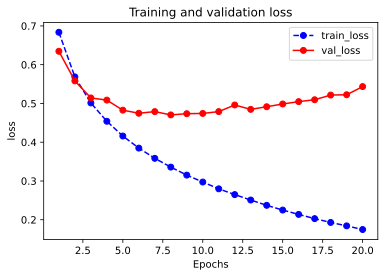

In [17]:
plot_metric(dfhistory,"loss")

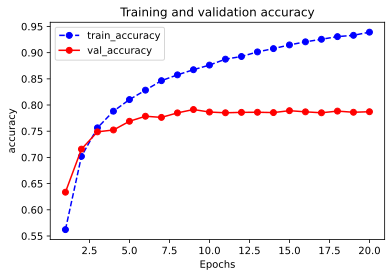

In [18]:
plot_metric(dfhistory,"accuracy")

In [19]:
model.evaluate(dl_test)

{'val_loss': 0.543543950945139, 'val_accuracy': 0.787200001001358}